---
# Model T - Transfer Learning, No Data Augmentation, Feature Extraction, RMSProp
> TODO:

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from PIL import Image

TensorFlow version: 2.12.0


---
#### Resizing the images for the VGG16 model

In [2]:
IMG_SIZE = 128

def resize_image(image_path, new_dimensions=(IMG_SIZE, IMG_SIZE)):
    with Image.open(image_path) as img:
        resized_img = img.resize(new_dimensions)
    return resized_img

def resize_images_in_directory(input_directory, output_directory, new_dimensions=(IMG_SIZE, IMG_SIZE)):
    os.makedirs(output_directory, exist_ok=True)
    for filename in os.listdir(input_directory):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)
            resized_img = resize_image(image_path, new_dimensions)
            resized_img.save(output_path)

resize_images_in_directory('../data/test/000_airplane', f'../data/test_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/test/001_automobile', f'../data/test_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/test/002_bird', f'../data/test_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/test/003_cat', f'../data/test_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/test/004_deer', f'../data/test_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/test/005_dog', f'../data/test_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/test/006_frog', f'../data/test_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/test/007_horse', f'../data/test_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/test/008_ship', f'../data/test_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/test/009_truck', f'../data/test_resized_{IMG_SIZE}/009_truck')
resize_images_in_directory('../data/train1/000_airplane', f'../data/train1_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/train1/001_automobile', f'../data/train1_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/train1/002_bird', f'../data/train1_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/train1/003_cat', f'../data/train1_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/train1/004_deer', f'../data/train1_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/train1/005_dog', f'../data/train1_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/train1/006_frog', f'../data/train1_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/train1/007_horse', f'../data/train1_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/train1/008_ship', f'../data/train1_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/train1/009_truck', f'../data/train1_resized_{IMG_SIZE}/009_truck')
resize_images_in_directory('../data/train2/000_airplane', f'../data/train2_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/train2/001_automobile', f'../data/train2_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/train2/002_bird', f'../data/train2_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/train2/003_cat', f'../data/train2_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/train2/004_deer', f'../data/train2_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/train2/005_dog', f'../data/train2_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/train2/006_frog', f'../data/train2_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/train2/007_horse', f'../data/train2_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/train2/008_ship', f'../data/train2_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/train2/009_truck', f'../data/train2_resized_{IMG_SIZE}/009_truck')
resize_images_in_directory('../data/train3/000_airplane', f'../data/train3_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/train3/001_automobile', f'../data/train3_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/train3/002_bird', f'../data/train3_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/train3/003_cat', f'../data/train3_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/train3/004_deer', f'../data/train3_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/train3/005_dog', f'../data/train3_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/train3/006_frog', f'../data/train3_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/train3/007_horse', f'../data/train3_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/train3/008_ship', f'../data/train3_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/train3/009_truck', f'../data/train3_resized_{IMG_SIZE}/009_truck')
resize_images_in_directory('../data/train4/000_airplane', f'../data/train4_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/train4/001_automobile', f'../data/train4_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/train4/002_bird', f'../data/train4_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/train4/003_cat', f'../data/train4_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/train4/004_deer', f'../data/train4_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/train4/005_dog', f'../data/train4_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/train4/006_frog', f'../data/train4_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/train4/007_horse', f'../data/train4_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/train4/008_ship', f'../data/train4_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/train4/009_truck', f'../data/train4_resized_{IMG_SIZE}/009_truck')
resize_images_in_directory('../data/train5/000_airplane', f'../data/train5_resized_{IMG_SIZE}/000_airplane')
resize_images_in_directory('../data/train5/001_automobile', f'../data/train5_resized_{IMG_SIZE}/001_automobile')
resize_images_in_directory('../data/train5/002_bird', f'../data/train5_resized_{IMG_SIZE}/002_bird')
resize_images_in_directory('../data/train5/003_cat', f'../data/train5_resized_{IMG_SIZE}/003_cat')
resize_images_in_directory('../data/train5/004_deer', f'../data/train5_resized_{IMG_SIZE}/004_deer')
resize_images_in_directory('../data/train5/005_dog', f'../data/train5_resized_{IMG_SIZE}/005_dog')
resize_images_in_directory('../data/train5/006_frog', f'../data/train5_resized_{IMG_SIZE}/006_frog')
resize_images_in_directory('../data/train5/007_horse', f'../data/train5_resized_{IMG_SIZE}/007_horse')
resize_images_in_directory('../data/train5/008_ship', f'../data/train5_resized_{IMG_SIZE}/008_ship')
resize_images_in_directory('../data/train5/009_truck', f'../data/train5_resized_{IMG_SIZE}/009_truck')

> We resize the images to 128x128 pixels to fit the VGG16 model.  
> With this image size, we expect a 4 x 4 x 512 feature map after the convolutional base.  

---
#### Group Datasets

In [3]:
train_dirs = ['../data/train1_resized_128', '../data/train3_resized_128', '../data/train4_resized_128', '../data/train5_resized_128']
validation_dir = '../data/train2_resized_128'
test_dir = '../data/test_resized_128'

> ((2221985 + 2221986) % 5) + 1 = 2  
> Validation set: train2.  

---
####  Count Images in Categories

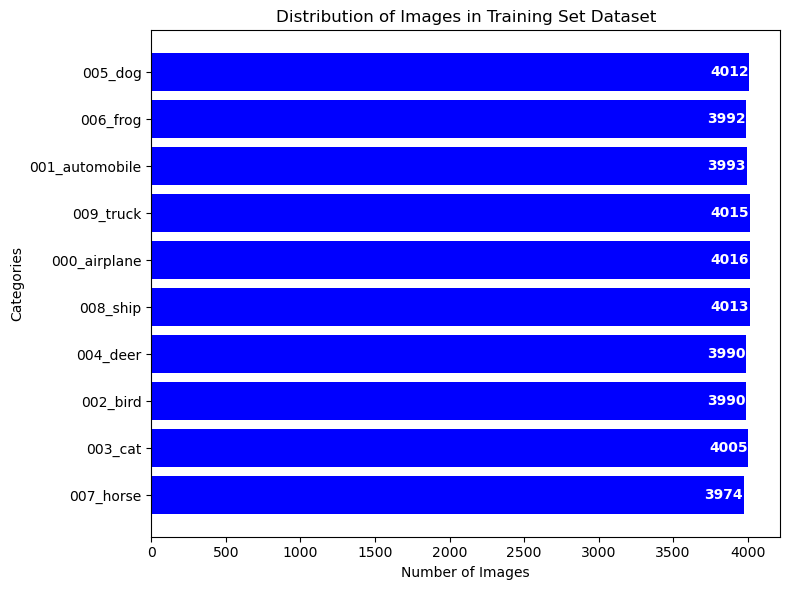

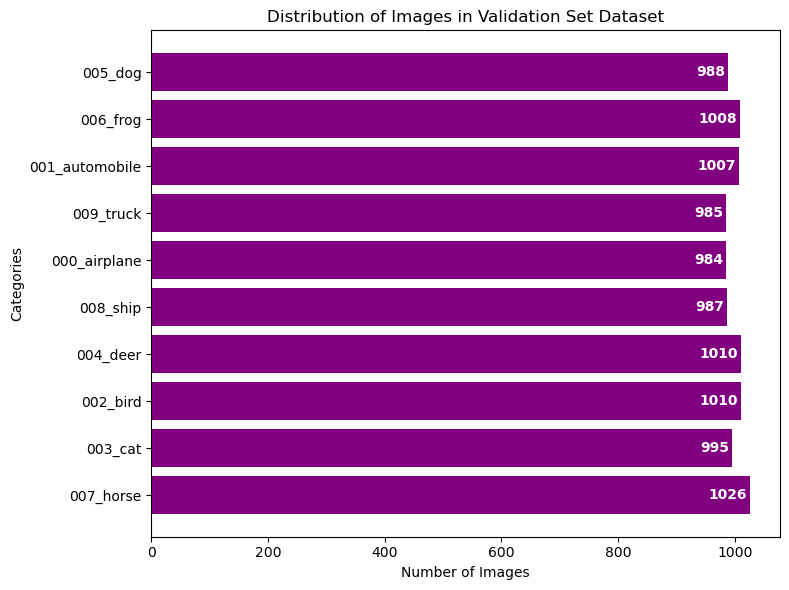

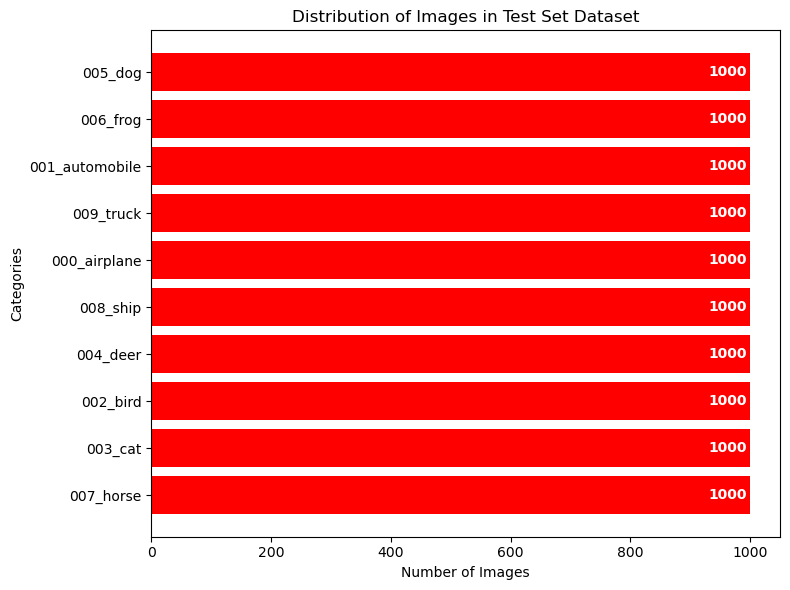

In [4]:
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    category_counts = {}
    for category in categories:
        category_counts[category] = len(os.listdir(os.path.join(directory, category)))
    return category_counts

train_counts_each_dir = [count_images_in_categories(train_dir) for train_dir in train_dirs]
validation_counts = count_images_in_categories(validation_dir)
test_counts = count_images_in_categories(test_dir)
train_counts = {category: sum([count.get(category, 0) for count in train_counts_each_dir]) for category in train_counts_each_dir[0]}

def plot_statistics(dataset_name, category_counts, color):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    num_categories = len(categories)
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(num_categories), counts, color=color, alpha=1)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, str(count), va='center', ha='right', color='white', fontweight='bold')

    plt.ylabel('Categories')
    plt.xlabel('Number of Images')
    plt.yticks(range(num_categories), categories)
    plt.title(f'Distribution of Images in {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

plot_statistics('Training Set', train_counts, 'blue')
plot_statistics('Validation Set', validation_counts, 'purple')
plot_statistics('Test Set', test_counts, 'red')

> We count the images of each category in each folder and plot the distribution.  
> We see that there are minor deviations the number of samples of each category in the train dataset and a bit more in the validation dataset. 

---
#### Create Datasets

In [5]:
BATCH_SIZE = 64
NUM_CLASSES = len(train_counts)

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

class_names = train_datasets[0].class_names

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE) # We tried without shuffle and prefetch
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


> We define the batch size of 64 and create an array with the label's names.  
> We define the number of classes as the number of categories.
> We create the train dataset by concatenating them, we shuffle the samples before each epoch and prefetch them to memory.  
> We do the same for the validation and test dataset except shuffling which is unnecessary.

---
#### Dataset Analysis

In [6]:
for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

data batch shape: (64, 128, 128, 3)
labels batch shape: (64,)


> We have batches of 64 images, 128 by 128 pixels with 3 channels (RGB).  
> We also have batches of 64 labels, one for each image.  

---
#### Dataset vizualization

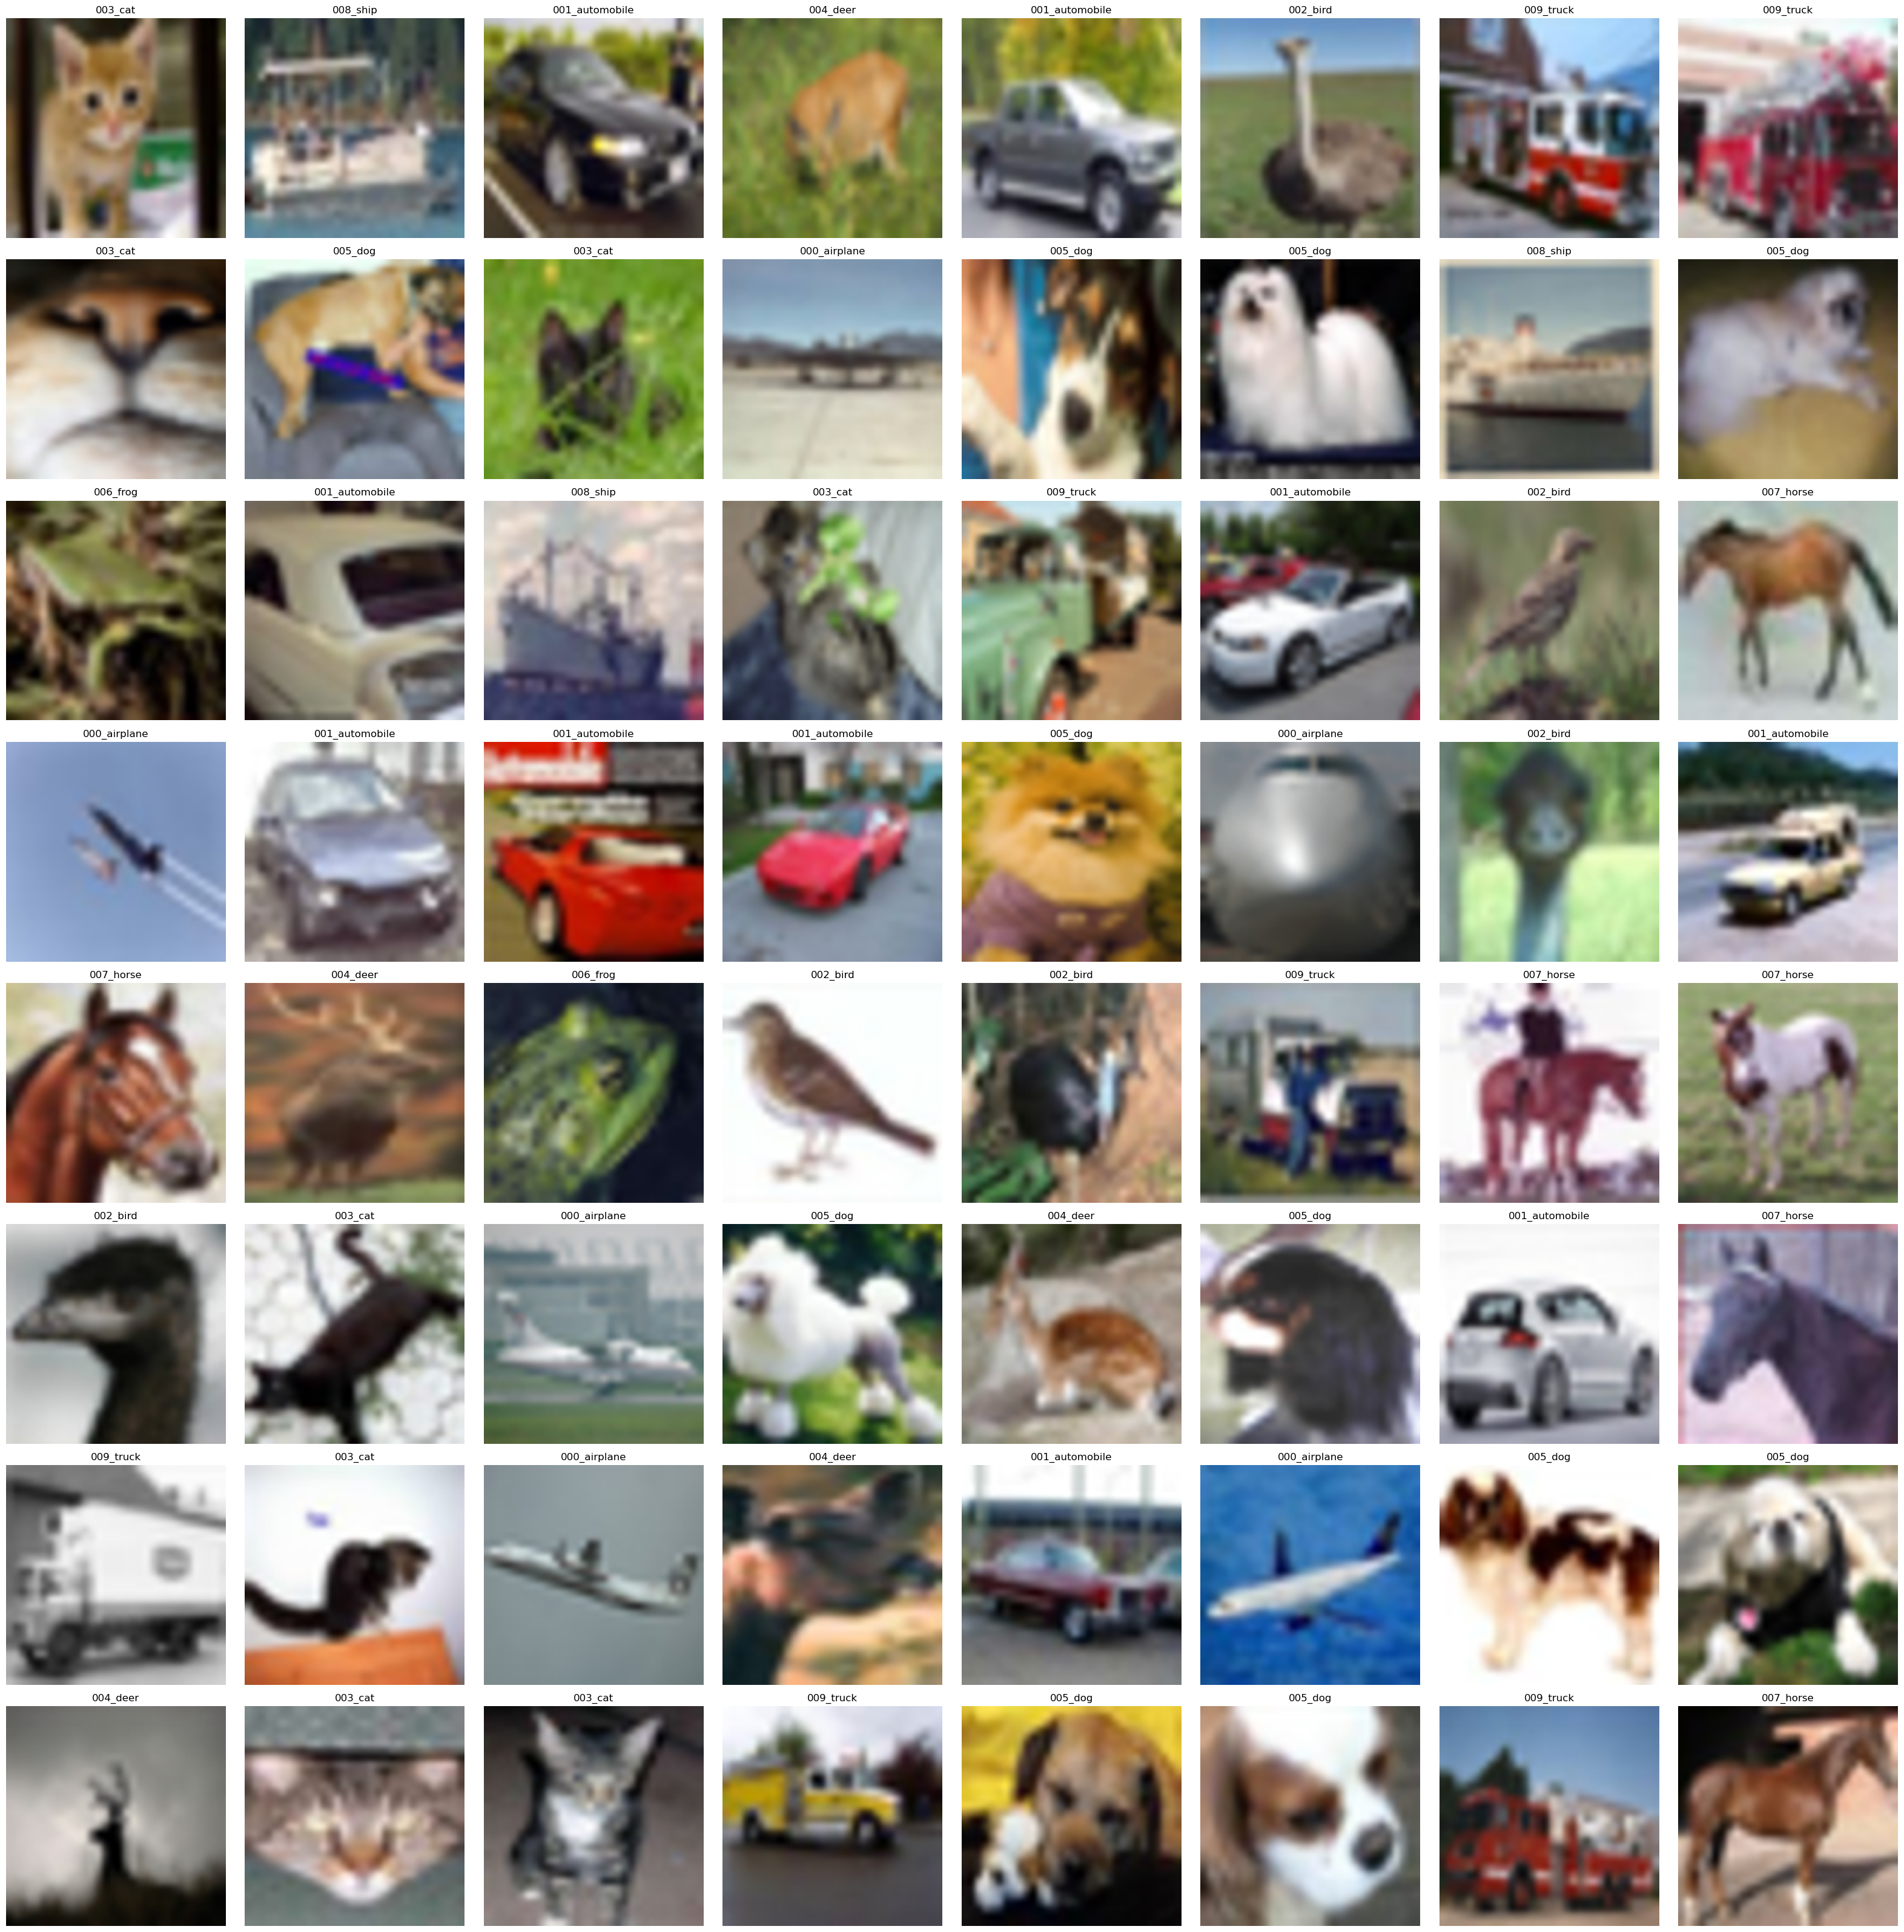

In [7]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(32, 32))
    for i in range(len(images)):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
        plt.tight_layout()
    plt.show()

> We print a random batch of images from the train dataset along with their respective labels.  
> We see that the images are of different categories and are now of 128 x 128 pixels despite not having gained quality.

---
#### Loading the VGG16 Model

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

> We load the VGG16 model with the imagenet weights, without the top layer and with the input shape of 128 x 128 pixels and 3 channels.

---
#### Feature Extraction

In [9]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 221ms/step


> We extract the features from the convolutional base of the VGG16 model for each dataset.

---
### Saving the features and labels

In [10]:
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_train_features.npy', train_features)
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_train_labels.npy', train_labels)
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_val_features.npy', val_features)
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_val_labels.npy', val_labels)
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_test_features.npy', test_features)
np.save('../features/model_t_no_data_augm_feat_ext_rmsprop_test_labels.npy', test_labels)

---
### Loading the features and labels

In [11]:
train_features = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_train_features.npy')
train_labels = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_train_labels.npy')
val_features = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_val_features.npy')
val_labels = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_val_labels.npy')
test_features = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_test_features.npy')
test_labels = np.load('../features/model_t_no_data_augm_feat_ext_rmsprop_test_labels.npy')

---
#### Dense Network Arquitecture

In [12]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(0.01))(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650   

> We define a dense network with two hidden layers of 256 and 64 neurons respectively.  
> We use the ReLU activation function and L2 regularization with a factor of 0.01.  
> We also use dropout layers with 0.5 and 0.25 dropout rates.  
> The output layer has the softmax activation function.  

---
#### Model Compilation

In [13]:
initial_learning_rate = 0.001
optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='../models/model_t_no_data_augm_feat_ext_rmsprop_model_classifier.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

> We compile the model with the RMSProp optimizer, the sparse categorical crossentropy loss function and the accuracy metric.  
> We define the ReduceLROnPlateau and EarlyStopping callbacks.  
> We also define a ModelCheckpoint callback to save the best model based on the validation loss.  
> We monitor the validation loss.  
> We reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs.  
> We stop the training if the validation loss does not improve for 10 epochs and restore the best weights.  

---
#### Model Training

In [14]:
history = model.fit(train_features,
                    train_labels,
                    epochs=40,
                    validation_data=(val_features, val_labels),
                    callbacks=[callbacks, lr_scheduler, early_stopping_callback])

Epoch 1/40
1245/1250 [============================>.] - ETA: 0s - loss: 2.5734 - accuracy: 0.6682
Epoch 1: val_loss improved from inf to 1.08060, saving model to ../models/model_t_no_data_augm_feat_ext_rmsprop_model_classifier.h5
1250/1250 [==============================] - 10s 8ms/step - loss: 2.5677 - accuracy: 0.6687 - val_loss: 1.0806 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 2/40
1245/1250 [============================>.] - ETA: 0s - loss: 1.1972 - accuracy: 0.7764
Epoch 2: val_loss improved from 1.08060 to 0.92615, saving model to ../models/model_t_no_data_augm_feat_ext_rmsprop_model_classifier.h5
1250/1250 [==============================] - 9s 8ms/step - loss: 1.1966 - accuracy: 0.7765 - val_loss: 0.9261 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/40
1246/1250 [============================>.] - ETA: 0s - loss: 1.1178 - accuracy: 0.7797
Epoch 3: val_loss improved from 0.92615 to 0.86858, saving model to ../models/model_t_no_data_augm_feat_ext_rmsprop_model_classifier.h5
1250/1250

> We train the model with the extracted features and labels.
> We train the model for 40 epochs.
> We use the validation dataset for validation.

---
#### Save Model History

In [15]:
with open("../history/model_t_no_data_augm_feat_ext_rmsprop.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Training Visualization

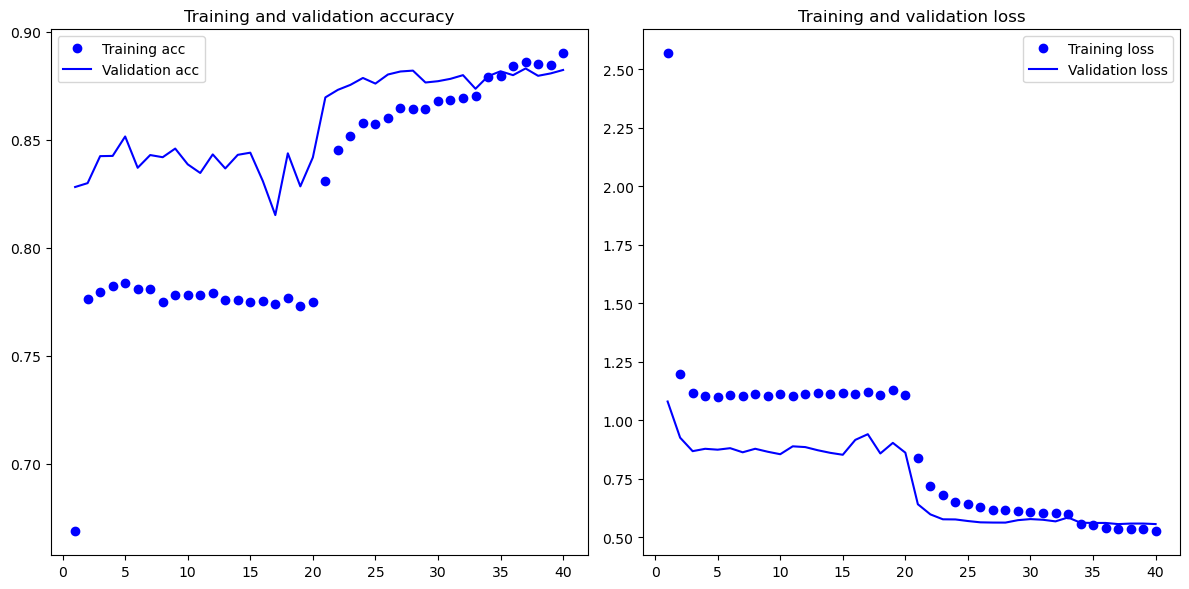

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

> TODO:

---
#### Building the full model (VGG16 + Dense Network)

In [17]:
conv_base.trainable = False
inputs = keras.Input(shape=(128, 128, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

full_model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"])

full_model.save('../models/model_t_no_data_augm_feat_ext_rmsprop_full_model.h5')

> TODO:

---
#### Model Evaluation

In [18]:
val_loss, val_acc = full_model.evaluate(validation_dataset)
print('Model Validation Loss: ', val_loss)
print('Model Validation Accuracy: ', val_acc)

157/157 [==============================] - 137s 871ms/step - loss: 0.5572 - accuracy: 0.1007
Model Validation Loss:  0.5572170615196228
Model Validation Accuracy:  0.1006999984383583


---
#### Model Testing

In [19]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 286ms/step


---
#### Confusion Matrix

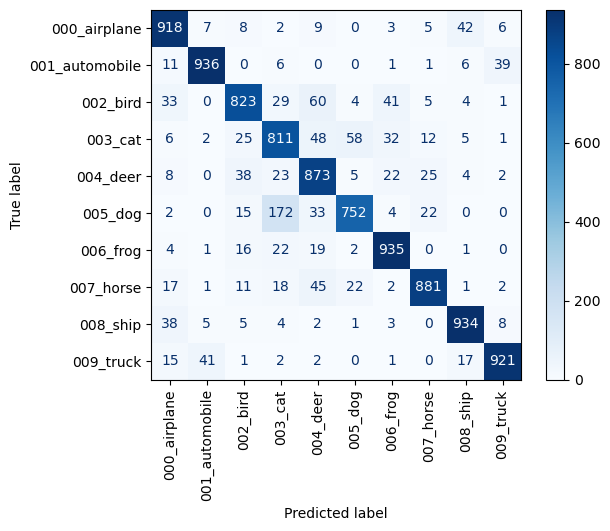

In [20]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that the model has some trouble distinguishing between some categories.  
- The model has a hard time distinguishing between the categories 003_cat and 005_dog.  
- The model also has a hard time distinguishing between some other categories but the error is not as significant.  
- The model has an acceptable performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.

---
#### ROC Curve Analysis

In [ ]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- We see that the model has a good performance on the ROC curve for most categories.  
- The categories 003_cat, 003_bird, 005_dog and 004_deer have the worst AUC (Area Under Curve) performance.
- A perfect AUC of 1.0 would mean that the model classifies all true positives and true negatives correctly.

---
#### Performance Metrics
> Accuracy is the proportion of correctly predicted instances out of the total instances.  
> Precision is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
> Weighted precision calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
> Recall is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
> Weighted recall calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
> The F1-score is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
> Weighted F1-score calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.  

In [21]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 87.84%
Precision - Macro: 88.08%
Recall - Macro: 87.84%
F1-score - Macro: 87.84%
Precision - Weighted: 88.08%
Recall - Weighted: 87.84%
F1-score - Weighted: 87.84%


# Conclusion
- We have trained a model with no data augmentation, using the Sparse Categorical Crossentropy loss function and the RMSProp optimizer.  
- We experimented with various architectures, and this one yielded the best results:  
    - Different learning rates were tested; this rate performed best.  
    - Various batch sizes were explored; this size was optimal.  
    - Multiple optimizers were evaluated; RMSProp was the most effective.
    - Several regularization values were tried; these values worked best.
    - Different dropout rates were assessed; this rate provided the best results.
    - Various epoch counts were tested; 40 epochs were optimal.
    - Different kernel sizes were considered; this size was most effective.
    - Various numbers of kernels were tested; this configuration was best.
    - Different numbers of layers were evaluated; this architecture was optimal.
- For the next notebook, we will retain this architecture to test data augmentation techniques.
- We opted to add Batch Normalization after each convolutional layer.
- We used L1 and L2 regularization on both convolutional and dense layers.
- Dropout was applied to the dense layers.
- The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
- Overfitting was observed after 15 epochs, but the best model was saved at the 40th epoch.
- The model achieved an accuracy of 84.5% on the test set.
- We evaluated the model using a confusion matrix to analyze its performance on each category.
- We evaluated the model using ROC curves for a deeper performance analysis.
- Performance on the test set was good, with:
    - Macro F1-score: 84.49%
    - Weighted F1-score: 84.49%
    - Macro precision: 84.49%
    - Weighted precision: 84.49%
    - Macro recall: 84.5%
    - Weighted recall: 84.5%

### Future Work
- In the next phase, we will:
    - Implement and test various data augmentation techniques to further improve model generalization.
    - Explore additional regularization methods to address overfitting.